In [19]:
# 导入所需的库
import pandas as pd  # 用于数据处理的库
import math  # 数学函数库
import matplotlib.pyplot as plt  # 数据可视化库
import numpy as np  # 数值计算库
import scipy  # 科学计算库

# 导入scikit-learn库中的评估指标
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler  # 数据归一化工具

# 导入TensorFlow和Keras库
import tensorflow as tf
from tensorflow import keras, data

# 导入Keras中的层和模型构建工具
from keras.layers import Input, LSTM, Attention, Dense, Layer
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping  # 提前停止功能
from random import random  # 随机数生成


In [20]:
# 设置随机种子以获取可重复的结果
seed_value = 0  # 定义随机种子的值为0

# 设置`PYTHONHASHSEED`环境变量为固定值以确保Python的hash值可重复
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)  # 将环境变量设置为seed_value，确保hash值的可重复性

# 设置Python内置伪随机数生成器的种子为固定值
import random
random.seed(seed_value)  # 将随机数生成器的种子设置为0，以确保可预测的随机数输出

# 设置NumPy伪随机数生成器的种子为固定值
np.random.seed(seed_value)  # 将NumPy的随机数生成器的种子设置为0，以确保可重复的随机数生成

# 设置TensorFlow伪随机数生成器的种子为固定值
tf.random.set_seed(seed_value)  # 将TensorFlow的随机数生成器的种子设置为0，确保模型训练的可重复性


In [3]:
    # IEEE PHM 2014 Data Challenge Dataset without ripples
df_part1 = pd.read_csv(r"C:\Users\12744\Desktop\孙岩博士答辩资料\remaining-useful-life-prediction-for-proton-exchange-membrane-fuel-cells-main\IEEE 2014 PHM Challenge Dataset\FC1_Without_Ripples\FC1_Ageing_part1.csv", encoding = "ISO-8859-1")
df_part2 = pd.read_csv(r"C:\Users\12744\Desktop\孙岩博士答辩资料\remaining-useful-life-prediction-for-proton-exchange-membrane-fuel-cells-main\IEEE 2014 PHM Challenge Dataset\FC1_Without_Ripples\FC1_Ageing_part2.csv", encoding = "ISO-8859-1")
df_part3 = pd.read_csv(r"C:\Users\12744\Desktop\孙岩博士答辩资料\remaining-useful-life-prediction-for-proton-exchange-membrane-fuel-cells-main\IEEE 2014 PHM Challenge Dataset\FC1_Without_Ripples\FC1_Ageing_part3.csv", encoding = "ISO-8859-1")
frames = [df_part1, df_part2, df_part3] #将三个数据帧合并为一个数据集
phm_dataset_1 = pd.concat(frames, ignore_index = True).astype('float32')# 合并并转换数据类型为float32


In [21]:
# 阐明统计特征
phm_dataset_1.describe().transpose()#计数（count）、平均值（mean）、标准差（std）、最小值（min）、四分位数（25%、50%、75%）以及最大值（max）

,count,mean,std,min,25%,50%,75%,max
Time (h),143862.0,551.996948,346.425232,0.000000,249.103676,550.801270,852.507233,1154.213379
U1 (V),143862.0,0.659456,0.008198,0.641000,0.652000,0.657000,0.666000,0.678000
U2 (V),143862.0,0.654759,0.007849,0.629000,0.649000,0.654000,0.661000,0.673000
U3 (V),143862.0,0.650458,0.009855,0.621000,0.642000,0.649000,0.658000,0.672000
U4 (V),143862.0,0.654692,0.007642,0.619000,0.648000,0.654000,0.661000,0.673000
U5 (V),143862.0,0.650674,0.009347,0.583000,0.643000,0.650000,0.659000,0.671000
Utot (V),143862.0,3.270040,0.042673,3.093000,3.234000,3.263000,3.305000,3.365000
J (A/cm²),143862.0,0.702568,0.000979,0.700660,0.702070,0.702370,0.702560,0.707350
I (A),143862.0,70.256783,0.097948,70.066002,70.207001,70.237000,70.255997,70.735001
TinH2 (°C),143862.0,27.890667,0.593979,24.955999,27.684999,27.858999,28.049000,32.777000


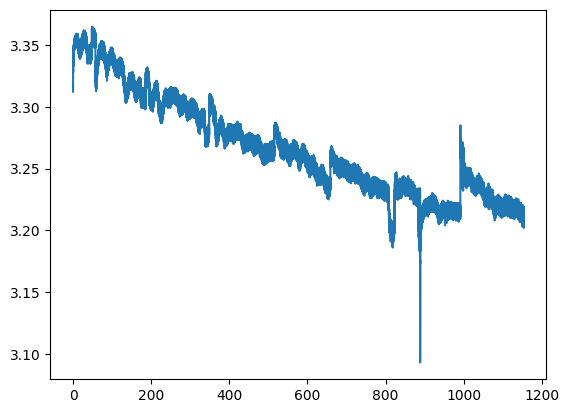

In [5]:
# Plot stack voltage as a function of time
plt.plot(list(phm_dataset_1['Time (h)']), list(phm_dataset_1['Utot (V)']))

In [6]:
# IEEE PHM 2014 Data Challenge Dataset with ripples
df_part1 = pd.read_csv(r"C:\Users\12744\Desktop\孙岩博士答辩资料\remaining-useful-life-prediction-for-proton-exchange-membrane-fuel-cells-main\IEEE 2014 PHM Challenge Dataset\Full_FC2_With_Ripples\FC2_Ageing_part1.csv", encoding = "ISO-8859-1")
df_part2 = pd.read_csv(r"C:\Users\12744\Desktop\孙岩博士答辩资料\remaining-useful-life-prediction-for-proton-exchange-membrane-fuel-cells-main\IEEE 2014 PHM Challenge Dataset\Full_FC2_With_Ripples\FC2_Ageing_part2.csv", encoding = "ISO-8859-1")
phm_dataset_2 = pd.concat([df_part1, df_part2], ignore_index = True).dropna(axis=1, how='all').astype('float32')


In [7]:
# Elucidate statistical features
phm_dataset_2.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Time (h),127370.0,491.865234,302.337219,0.000000,223.494026,490.592636,754.495773,1020.536316
U1 (V),127370.0,0.651061,0.014793,0.575000,0.646000,0.650000,0.655000,0.999000
U2 (V),127370.0,0.646312,0.014892,0.577000,0.641000,0.645000,0.650000,0.999000
U3 (V),127370.0,0.643958,0.014475,0.579000,0.639000,0.644000,0.648000,0.993000
U4 (V),127370.0,0.643327,0.015167,0.571000,0.637000,0.642000,0.648000,0.997000
U5 (V),127370.0,0.635102,0.016423,0.563000,0.628000,0.633000,0.641000,0.998000
Utot (V),127370.0,3.219760,0.075481,2.865000,3.191000,3.213000,3.241000,4.986000
J (A/cm²),127370.0,0.699381,0.028743,0.000250,0.700560,0.700610,0.700760,0.944950
I (A),127370.0,69.938072,2.874264,0.025000,70.056000,70.060997,70.075996,94.495003
TinH2 (°C),127370.0,27.270519,1.965247,24.087000,25.049999,28.662001,29.027000,29.643999


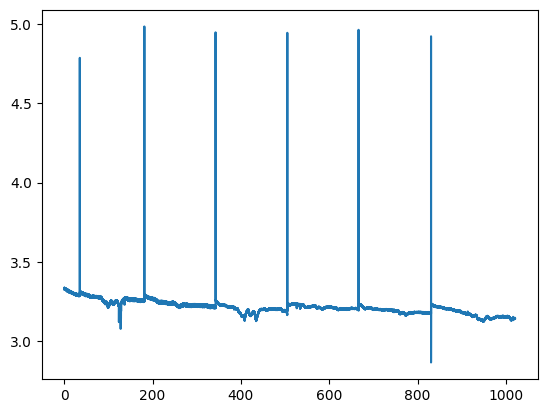

In [8]:
# Plot stack voltage as a function of time
plt.plot(list(phm_dataset_2['Time (h)']), list(phm_dataset_2['Utot (V)']))

In [9]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    """
    Multivariate Time Series
    Convert series to supervised learning
    Standard practice in time series forecasting to use lagged observations (e.g. t-1) as input variables to forecast the current time step (t)
    Code sourced from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

### Model Implementation

In [10]:
class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        # inputs.shape = (batch_size, time_steps, input_dim)
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=[2, 0]) + self.b)
        score = tf.tensordot(score, self.u, axes=[2, 0])
        attention_weights = tf.nn.softmax(score, axis=1)

        # Multiply attention weights with the inputs to get the context vector
        context_vector = attention_weights[..., tf.newaxis] * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # Return a 3D output
        context_vector = tf.expand_dims(context_vector, 1)
        context_vector = tf.tile(context_vector, [1, inputs.shape[1], 1])
        
        return context_vector

In [11]:
BATCH_SIZE = 96
class DA_LSTM():
    """
    Implements structure, training, and validation of neural network models.
    """
    def __init__(self, x_train, y_train, x_valid, y_valid, x_test, y_test, volt_scaler) -> None:
        """
        volt_scaler is the MinMaxScaler object used to normalize Utot(V) in range (0,1)
        """
        self.mae = keras.losses.MeanAbsoluteError()
        self.mse = keras.losses.MeanSquaredError()
        self.x_train, self.y_train = x_train, y_train  # Training set
        self.x_valid, self.y_valid = x_valid, y_valid # Validation set
        self.x_test, self.y_test = x_test, y_test   # Test set
        self.volt_scaler = volt_scaler
        # Hyperparameter tuning results for static loading dataset with 50% data as training set
        # stored as attributes for easy accessibility
        self.opt_LSTM_LR = 0.001 #Adam
        
    def build_LSTM_model(self, activator, optimizer):
        """
        LSTM Network.
        Use bidir_LSTM_layer in keras.Sequential() to implement a Bidirectional LSTM.
        """
        keras.backend.clear_session()
        output_neurons = 1
        input_layer = Input(shape=(self.x_train.shape[1], self.x_train.shape[2]))
        lstm_layer_1 = LSTM(256, return_sequences=True, activation=activator)(input_layer)

        # Self-attention layer after lstm_layer_1
        lstm_layer_1_attention = SelfAttention(units=16)(lstm_layer_1)
        
        lstm_layer_2 = LSTM(256, return_sequences=True, activation=activator, dropout=0.4)(lstm_layer_1_attention)
        lstm_layer_3 = LSTM(128, return_sequences=True, activation=activator)(lstm_layer_2)
        
        # Scaled dot-product attention layer       
        lstm_layer_3_attention = Attention()([lstm_layer_3, lstm_layer_3])
        
        lstm_layer_4 = LSTM(128, activation=activator, dropout=0.4)(lstm_layer_3_attention)

        output_layer = Dense(output_neurons)(lstm_layer_4)

        lstm_model = Model(inputs=input_layer, outputs=output_layer)
#         lstm_model.reset_states()
        for layer in lstm_model.layers:
            if hasattr(layer, 'reset_states'):
                layer.reset_states()
        lstm_model.compile(optimizer = optimizer, loss = self.mse)
        lstm_model.summary()
        return lstm_model



    def train_model(self, model, epoch_size = 150, BATCH_SIZE = BATCH_SIZE):
        """
        Train the model with specified epochs and batch size.
        Default values of epoch_size and BATCH_SIZE used when not supplied.
        """
        early_stop = EarlyStopping(monitor = 'val_loss', patience = 50, mode = 'min', restore_best_weights=True)
        
        history = model.fit(self.x_train, self.y_train, epochs = epoch_size, batch_size = BATCH_SIZE, callbacks = [early_stop],
                validation_data=  (self.x_valid, self.y_valid), shuffle = False)
        
        return history


    def predict(self, model):
        """
        model: DNN model built
        volt_scaler: Scaler used to fit independent variable (stack voltage) data during initial data processing
        """
        # Predict
        yhat = model.predict(self.x_test)
        x_test = self.x_test.reshape((self.x_test.shape[0], self.x_test.shape[2]))
        inv_yhat = np.concatenate((yhat, x_test[:, 1:]), axis=1)
        inv_yhat = self.volt_scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        y_test = self.y_test.reshape((len(self.y_test), 1))
        inv_y = np.concatenate((y_test, x_test[:, 1:]), axis=1)
        inv_y = self.volt_scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        return inv_y, inv_yhat


    def plot_loss_curves(self, history, epoch_size):
        """
        Visualize Model Results
        """
        training_loss = history.history['loss']
        validation_loss = history.history['val_loss']
        epochs = range(1, epoch_size + 1)
        plt.figure()
        plt.plot(epochs, training_loss, label = 'Training Loss')
        plt.plot(epochs, validation_loss, label = 'Validation Loss')
        plt.legend()
        plt.show()
        plt.savefig('training.png')


    def evaluate_metrics(self, y_true, y_pred):
        """
        Return RMSE
        """
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        
        return rmse


    def evaluate_loss_function(self, y_true, y_pred):
        """
        RMSE is chosen as the loss function for hyperparameter optimization
        """
        return math.sqrt(mean_squared_error(y_true, y_pred))
    
    def plot_prediction_results(self, y_train, y_valid, y_test, y_true, y_pred):
        """
        Plot the predicted voltage as a function of time
        """
        training_time_arr = [_ for _ in range(len(y_train))]
        validation_time_arr = [_ for _ in range(len(y_train), len(y_train) + len(y_valid))]
        prediction_time_arr = [_ for _ in range(len(y_train) + len(y_valid), len(y_train) + len(y_valid) + len(y_test))]
        plt.axvline(x = training_time_arr[0], linestyle = '--')
        plt.axvline(x = training_time_arr[-1], linestyle = '--')
        plt.axvline(x = validation_time_arr[-1], linestyle = '--')
        plt.ylabel('Stack Voltage (V)')
        plt.xlabel('Time (h)')
        plt.plot(training_time_arr, y_train, label = 'Training voltage', color=(0, 0.8, 1, 0.4))
        plt.plot(validation_time_arr, y_valid, label = 'Validation voltage', color=(1, 0, 0.80, 0.4))
        plt.plot(prediction_time_arr, y_true, label = 'True voltage', color=(0, 1, 0, 0.6))
        plt.plot(prediction_time_arr, y_pred, label = 'Predicted voltage', color=(1, 0, 0, 0.6))
        plt.legend(loc = 'upper right', prop = {'size': 8})
        # Download the image
        plt.savefig('result.png')


    def loop_model(self, n_loops = 50, df_type = 2):
        """
        Outputs the RMSE, and RUL Prediction RE over 50 trials as arrays
        Loop - Min, Max, Average of RMSE, predicted RUL, and relative error of predicted RUL over number of trials, default 50
        df_type = 1 corresponds to the static loading dataset
        df_type = 2 corresponds to the dynamic loading dataset
        Uncomment the line corresponding to the model you wish to evaluate
        """
        arr_RMSE, arr_RUL, arr_RUL_RE = list(), list(), list()
        for _ in range(n_loops):
            print("Trial ", _+1 ," of", n_loops)
            # build the model
            model = self.build_LSTM_model('tanh', tf.keras.optimizers.Adam(learning_rate = self.opt_LSTM_LR))

            # training the model
            history = self.train_model(model, epoch_size = 150, BATCH_SIZE = BATCH_SIZE)
        
            #plot loss curves
            self.plot_loss_curves(history, epoch_size = len(history.history['loss']))
            
            # make prediction
            y_true, y_pred = self.predict(model)
            
            #evaluating the model
            rmse = self.evaluate_metrics(y_true, y_pred)
            
            # initial voltage for threshold chosen as first voltage in training set of each dataset
            threshold_4perc = 3.1971 if df_type == 2 else 3.2028
            validation_h = len(self.y_valid)
            true_failure_h = [i for i,v in enumerate(y_true) if v < threshold_4perc][0]
            true_RUL = validation_h + true_failure_h
            try:
                pred_failure_h = [i for i,v in enumerate(y_pred) if v < threshold_4perc][0]
            except IndexError:
                pred_failure_h = len(y_pred)
            
            # RUL = validation set time + time to failure
            pred_RUL = validation_h + pred_failure_h
            
            
            arr_RUL.append(pred_RUL) 
            arr_RUL_RE.append(abs(pred_RUL - true_RUL)/true_RUL)
            print(f"RMSE: {rmse}")
            arr_RMSE.append(rmse)
            
            #plot the prediction results
            self.plot_prediction_results(self.volt_scaler.inverse_transform(self.y_train), self.volt_scaler.inverse_transform(self.y_valid), self.y_test, y_true, y_pred)
            
            del model
            keras.backend.clear_session()

        arr_RMSE, arr_RUL, arr_RUL_RE = np.array(arr_RMSE), np.array(arr_RUL), np.array(arr_RUL_RE)
        min_RMSE, min_RUL, min_RUL_RE = arr_RMSE.min(), arr_RUL.min(), arr_RUL_RE.min()
        max_RMSE, max_RUL, max_RUL_RE = arr_RMSE.max(), arr_RUL.max(), arr_RUL_RE.max()
        avg_RMSE, avg_RUL, avg_RUL_RE = arr_RMSE.mean(), arr_RUL.mean(), arr_RUL_RE.mean()
        
        print("RMSE Array", arr_RMSE, end = '\n')
        print("RUL Array", arr_RUL, end = '\n')
        print("RUL_RE Array", arr_RUL_RE, end = '\n')
        print(f"Mean RMSE: {avg_RMSE}, Min RMSE: {min_RMSE}, Max RMSE: {max_RMSE}")
        print(f"True RUL: {true_RUL}, Min RUL: {min_RUL}, Mean RUL: {avg_RUL}, Max RUL: {max_RUL}")
        print(f"Min RUL_RE: {min_RUL_RE}, Mean RUL_RE: {avg_RUL_RE}, Max RUL_RE: {max_RUL_RE}")
        
        return arr_RMSE, arr_RUL, arr_RUL_RE, y_pred, y_true

### Dataset Processor Class

In [12]:
class df_handler():
    """
    Class implementing downsampling, Savitzky-Golay filtering,
    """
    def __init__(self, dataset: pd.DataFrame):
        self.fc_dataset = dataset


    def reconstruct_dataset(self):
        """
        Downsample the dataset at 1 h interval.
        Returns the sampled time indices, stack voltage, dataset, and features
        """
        time_original = self.fc_dataset['Time (h)']
        sampled_indexes = self.fc_dataset.astype('int32').drop_duplicates(subset = ['Time (h)']).index
        sampled_df = self.fc_dataset.iloc[sampled_indexes, :]
        time_h = sampled_df['Time (h)']
        volt_total = sampled_df['Utot (V)'].values.tolist()
        features = sampled_df.copy(deep = True).drop(labels = ['Time (h)', 'Utot (V)'], axis = 1)
        return time_h, volt_total, sampled_df, features


    def smooth_dataset(self, sampled_df):
        """
        Smooths the (sampled) dataset by Savitzky-Golay smoothing
        The window length and polynomial order may be tweaked by the variables window_length and polynomial_order, respectively.
        """
        window_length = 21
        polynomial_order = 2
        smoothed_dataset = pd.DataFrame()
        for col in sampled_df.columns[1:]: #Exclude Time (h) column
            smoothed_dataset[col] = scipy.signal.savgol_filter(sampled_df[col], window_length, polynomial_order)
        return smoothed_dataset


    def train_test_split(self, train_frac, smoothed_dataset):
        """
        Splits dataset into train-validation-test sets after smoothing features
        50% (520 h) train, 10% validation (115 h), 40% test (519 h) for FC1: wihout ripple dataset
        50% (460 h) train, 10% validation (102 h), 40% test (458 h) for FC2: ripple dataset
        train_frac: fraction of data to be used for training; of the remaining datset, 10% is for validation and the rest is the test set
        """
        sup_df = series_to_supervised(smoothed_dataset)
        num_cols = len(smoothed_dataset.columns)
        n = len(sup_df)
        
        # Drop variables not to predict at the next time step; predict only the stack's total voltage.
        # Do not drop column 29 with output voltage
        sup_dataset = sup_df.drop(columns = sup_df.columns[list(_ for _ in range(num_cols, 2*num_cols) if _ != 29)], axis = 1)
        sup_values = sup_dataset.values
        sup_train, sup_valid, sup_test = sup_values[:int(n*train_frac),:], sup_values[int(n*train_frac):int(n*(train_frac+0.1)),:], sup_values[int(n*(train_frac+0.1)):,:]
        features_train, features_valid, features_test = sup_train[:, :-1], sup_valid[:, :-1], sup_test[:, :-1]
        train_y, valid_y, test_y = sup_train[:, -1], sup_valid[:, -1], sup_test[:, -1]
        return features_train, train_y, features_valid, valid_y, features_test, test_y


    def normalize_split_sets(self, features_train, features_valid, features_test, train_y, valid_y, test_y):
        """
        Normalize the dataset features in the range (0, 1)
        """
        # Normalize features
        feature_scaler = MinMaxScaler(feature_range = (0, 1))
        normalized_train_features = feature_scaler.fit_transform(features_train)
        normalized_valid_features = feature_scaler.transform(features_valid)
        normalized_test_features = feature_scaler.transform(features_test)
        normalized_train_features = normalized_train_features.reshape((normalized_train_features.shape[0], 1, normalized_train_features.shape[1]))
        normalized_valid_features = normalized_valid_features.reshape((normalized_valid_features.shape[0], 1, normalized_valid_features.shape[1]))
        normalized_test_features = normalized_test_features.reshape((normalized_test_features.shape[0], 1, normalized_test_features.shape[1]))
        
        # Normalize output voltage
        volt_scaler = MinMaxScaler(feature_range = (0, 1))
        normalized_train_volt = volt_scaler.fit_transform(train_y.reshape(train_y.shape[0], 1))
        normalized_valid_volt = volt_scaler.transform(valid_y.reshape(valid_y.shape[0], 1))
        normalized_test_volt = volt_scaler.transform(test_y.reshape(test_y.shape[0], 1))
        return (normalized_train_features, normalized_train_volt, normalized_valid_features, normalized_valid_volt,
                              normalized_test_features, normalized_test_volt, volt_scaler)


    

### Preprocess the Dataset

In [13]:
# Reconstruct and smooth dataset 1
fc1 = df_handler(phm_dataset_1)
time_1, volt_1, df_1, features_1 = fc1.reconstruct_dataset()
smoothed_df_1 = fc1.smooth_dataset(df_1)
x_train_1, y_train_1, x_valid_1, y_valid_1, x_test_1, y_test_1 = fc1.train_test_split(0.5, smoothed_df_1)
x_train_s1, y_train_s1, x_valid_s1, y_valid_s1, x_test_s1, y_test_s1, volt_scaler_1 = \
                        fc1.normalize_split_sets(x_train_1, x_valid_1, x_test_1, y_train_1, y_valid_1, y_test_1)

In [14]:
# Reconstruct and smooth dataset 2
fc2 = df_handler(phm_dataset_2)
time_2, volt_2, df_2, features_2 = fc2.reconstruct_dataset()
smoothed_df_2 = fc2.smooth_dataset(df_2)
x_train_2, y_train_2, x_valid_2, y_valid_2, x_test_2, y_test_2 = fc2.train_test_split(0.5, smoothed_df_2)
x_train_s2, y_train_s2, x_valid_s2, y_valid_s2, x_test_s2, y_test_s2, volt_scaler_2 = \
                        fc2.normalize_split_sets(x_train_2, x_valid_2, x_test_2, y_train_2, y_valid_2, y_test_2)

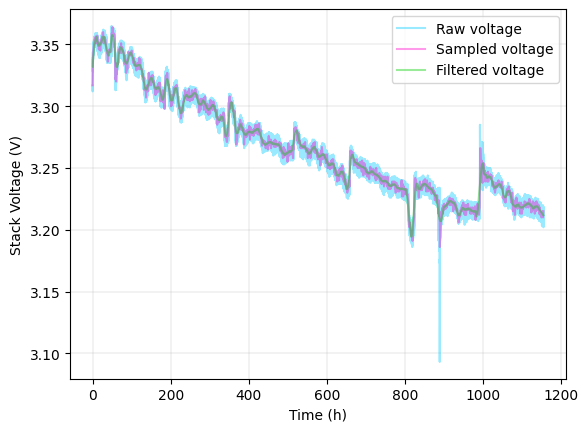

In [15]:
## PLOT FC1 RAW, FILTERED, AND SAMPLED VOLTAGES ##
plt.figure()
plt.plot(phm_dataset_1['Time (h)'], phm_dataset_1['Utot (V)'], color=(0, 0.8, 1, 0.4), label = 'Raw voltage')
plt.plot(time_1, volt_1, color=(1, 0, 0.80, 0.4), label = 'Sampled voltage')
plt.plot(time_1, smoothed_df_1['Utot (V)'], color=(0, 0.8, 0, 0.4), label = 'Filtered voltage')
plt.xlabel('Time (h)')
plt.ylabel('Stack Voltage (V)')
plt.legend(loc = 'upper right')
plt.grid(visible=True, which='major', color = 'darkgray', lw = 0.2)
# Download the figure
plt.savefig('time vs stack for FC1.png')

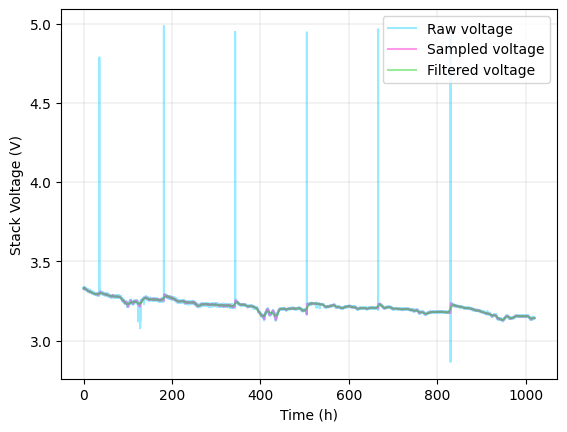

In [16]:
## PLOT FC2 RAW, FILTERED, AND SAMPLED VOLTAGES ##
plt.figure()
plt.plot(phm_dataset_2['Time (h)'], phm_dataset_2['Utot (V)'], color=(0, 0.8, 1, 0.4), label = 'Raw voltage')
plt.plot(time_2, volt_2, color=(1, 0, 0.80, 0.4), label = 'Sampled voltage')
plt.plot(time_2, smoothed_df_2['Utot (V)'],  color=(0, 0.8, 0, 0.4), label = 'Filtered voltage')
plt.xlabel('Time (h)')
plt.ylabel('Stack Voltage (V)')
plt.legend(loc = 'upper right')
plt.grid(visible=True, which='major', color = 'darkgray', lw = 0.2)
# Download the figure
plt.savefig('time vs stack for FC2.png')

### Model Evaluation

Trial  1  of 1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 1, 24)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 1, 256)            │         287,744 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ self_attention                │ (None, 1, 256)            │           4,128 │ lstm[0][0]                 │
│ (SelfAttention)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 1, 256)            │         525,312 │ self_attention[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 1, 128)            │         197,120 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention (Attention)         │ (None, 1, 128)            │               0 │ lstm_2[0][0], lstm_2[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ (None, 128)               │         131,584 │ attention[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1)                 │             129 │ lstm_3[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,146,017 (4.37 MB)

 Trainable params: 1,146,017 (4.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150


D:\python\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - loss: 0.4091 - val_loss: 0.0243
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3427 - val_loss: 0.0691
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2072 - val_loss: 0.1880
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0746 - val_loss: 0.1587
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0603 - val_loss: 0.1084
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0679 - val_loss: 0.0925
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0421 - val_loss: 0.0739
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0129 - val_loss: 0.0369
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0070 - val_loss: 0.0165
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0108 - val_loss: 0.0089
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0137 - val_loss: 0.0105

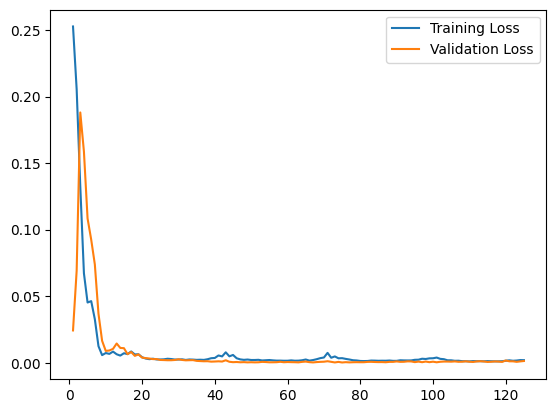

D:\python\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step
RMSE: 0.007370065210929195
RMSE Array [0.00737007]
RUL Array [577]
RUL_RE Array [1.43459916]
Mean RMSE: 0.007370065210929195, Min RMSE: 0.007370065210929195, Max RMSE: 0.007370065210929195
True RUL: 237, Min RUL: 577, Mean RUL: 577.0, Max RUL: 577
Min RUL_RE: 1.4345991561181435, Mean RUL_RE: 1.4345991561181435, Max RUL_RE: 1.4345991561181435


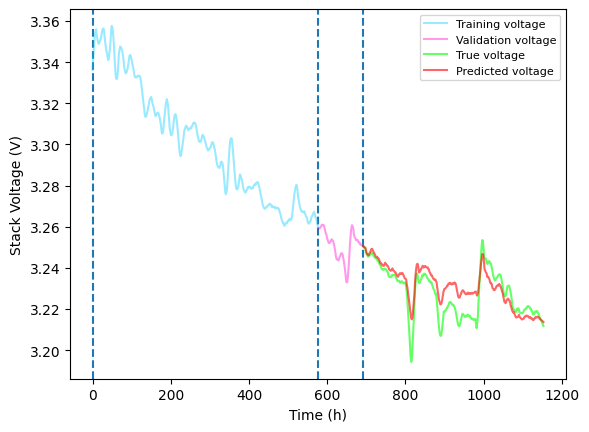

In [17]:
# Run to evaluate model performance
method = DA_LSTM(x_train_s1, y_train_s1, x_valid_s1, y_valid_s1, x_test_s1, y_test_s1, volt_scaler_1)

# Evaluate RMSE
arr_RMSE, arr_RUL, arr_RUL_RE, y_pred, y_true = method.loop_model(1,2)